In [1]:
#Libraries
import pandas as pd #Bibliothek für Datenmanipulation und -analyse.
import numpy as np #Bibliothek für mathematische Funktionen.
import matplotlib.pyplot as plt #Bibliothek zum Erstellen von statischen, animierten und interaktiven Visualisierungen.
import seaborn as sns #Bibliothek für statistische Datenvisualisierung basierend auf matplotlib.
# knn
from sklearn.neighbors import KNeighborsClassifier #K-Nearest Neighbors Klassifikator aus scikit-learn.
from sklearn import neighbors #Modul für K-Nearest Neighbors Algorithmen.
from sklearn.model_selection import cross_val_score #Funktion zur Bewertung eines Scores durch Kreuzvalidierung.
from sklearn.preprocessing import StandardScaler #Standardisiert Merkmale, indem der Mittelwert entfernt und auf die Einheitsskala skaliert wird.
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV #Funktion zum Aufteilen von Arrays oder Matrizen in zufällige Trainings- und Testsätze.
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay #Modul zur Berechnung von Klassifikationsmetriken.
from mlxtend.plotting import plot_decision_regions #Funktion zum Plotten von Entscheidungsregionen von Klassifikatoren.
# Entscheidungsbaum
from sklearn.tree import DecisionTreeClassifier #Entscheidungsbaum-Klassifikator aus scikit-learn.
# Random Forest
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier #Random Forest Klassifikator aus scikit-learn.
#Neurnales Netz
from tensorflow.keras.models import Sequential #Sequenzielles Modell aus Keras, einer High-Level-API für neuronale Netze.
from tensorflow.keras.utils import to_categorical #Funktion zur Umwandlung eines Klassenvektors (Ganzzahlen) in eine binäre Klassenmatrix.
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization #Dichte (vollständig verbundene) Schicht aus Keras.
from tensorflow.keras.callbacks import EarlyStopping #Callback zum Stoppen des Trainings, wenn eine überwachte Metrik sich nicht mehr verbessert.


# CSV-Datei einlesen
telefonkunden = pd.read_csv('telefonkunden.csv')

# Wie sieht der Datensatz aus?
print(telefonkunden.head)
telefonkunden.shape

<bound method NDFrame.head of      region  tenure  age  marital  address  income  ed  employ  retire  \
0         2      13   44        1        9    64.0   4       5     0.0   
1         3      11   33        1        7   136.0   5       5     0.0   
2         3      68   52        1       24   116.0   1      29     0.0   
3         2      33   33        0       12    33.0   2       0     0.0   
4         2      23   30        1        9    30.0   1       2     0.0   
..      ...     ...  ...      ...      ...     ...  ..     ...     ...   
995       3      10   39        0        0    27.0   3       0     0.0   
996       1       7   34        0        2    22.0   5       5     0.0   
997       3      67   59        0       40   944.0   5      33     0.0   
998       3      70   49        0       18    87.0   2      22     0.0   
999       3      50   36        1        7    39.0   3       3     0.0   

     gender  reside  custcat  
0         0       2        1  
1         0       6

(1000, 12)

In [6]:
# Es wurden Daten von 1000 Kunden gesammelt.
# Beschreibung des Datensatzes:
# Der Datensatz enthält Informationen über Telefonkunden, die in vier verschiedene Kundentypen (custcat) eingeteilt sind.
# Diese Kategorien können unterschiedliche Nutzungsmuster, Vertragslaufzeiten oder Kundenwerte repräsentieren.
# Die Daten umfassen 8 Merkmale, die mit der Kundenkategorie in Verbindung stehen: 
	#region: Region des Kunden
	#tenure: Dauer der Kundenbeziehung in Monaten
	#age: Alter des Kunden in Jahren
	#marital: Familienstand (0 = ledig, 1 = verheiratet)
	#address: Anzahl der Jahre, die der Kunde an seiner aktuellen Adresse lebt
	#income: Jährliches Einkommen des Kunden (in Tausend Dollar)
	#ed: Bildungsniveau des Kunden (Skala 1-5, 1=niedrig, 5=hoch)
	#employ: Anzahl der Beschäftigungsjahre
	#retire: Ruhestandstatus (0 = nein, 1 = ja)
	#gender: Geschlecht (0 = weiblich, 1 = männlich)
	#reside: Wohnort (1,8)
	#custcat: gewünschter Serviceumfang (Zielvariable für Klassifikation)
		#1 = Basic Service (grundlegender Service)
		#2 = E-Service (elektronischer Service)
		#3 = Plus Service (erweiterter Service)
        #4 = Total Service (vollständiger Service)

In [8]:
# 1. die Daten kennenlernen

# Mit dem Befehl describe() können summary statistics aufgerufen werden:
telefonkunden.describe()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
count,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.0220,35.526000,41.684000,0.495000,11.551000,77.535000,2.671000,10.987000,0.047000,0.517000,2.331000,2.487000
std,0.8162,21.359812,12.558816,0.500225,10.086681,107.044165,1.222397,10.082087,0.211745,0.499961,1.435793,1.120306
min,1.0000,1.000000,18.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.0000,17.000000,32.000000,0.000000,3.000000,29.000000,2.000000,3.000000,0.000000,0.000000,1.000000,1.000000
50%,2.0000,34.000000,40.000000,0.000000,9.000000,47.000000,3.000000,8.000000,0.000000,1.000000,2.000000,3.000000
75%,3.0000,54.000000,51.000000,1.000000,18.000000,83.000000,4.000000,17.000000,0.000000,1.000000,3.000000,3.000000
max,3.0000,72.000000,77.000000,1.000000,55.000000,1668.000000,5.000000,47.000000,1.000000,1.000000,8.000000,4.000000


In [2]:
# Anzahl der Kategorien und Einträge in jeder Kategorie
category_counts = telefonkunden['custcat'].value_counts()

# Ausgabe der Anzahl der Kategorien und Einträge
print("Anzahl der Kategorien:", len(category_counts))
print("Anzahl der Einträge in jeder Kategorie:")
print(category_counts)

Anzahl der Kategorien: 4
Anzahl der Einträge in jeder Kategorie:
custcat
3    281
1    266
4    236
2    217
Name: count, dtype: int64


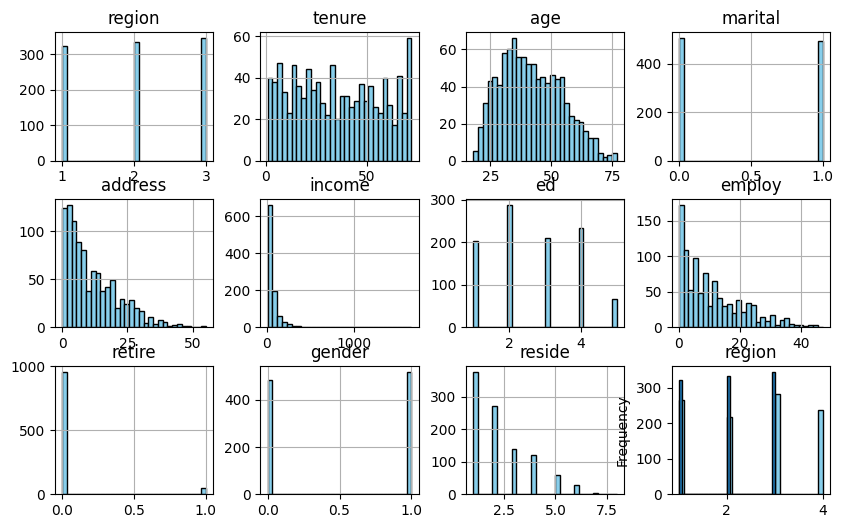

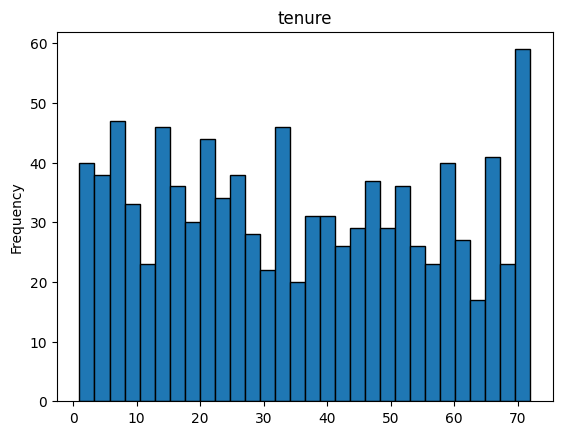

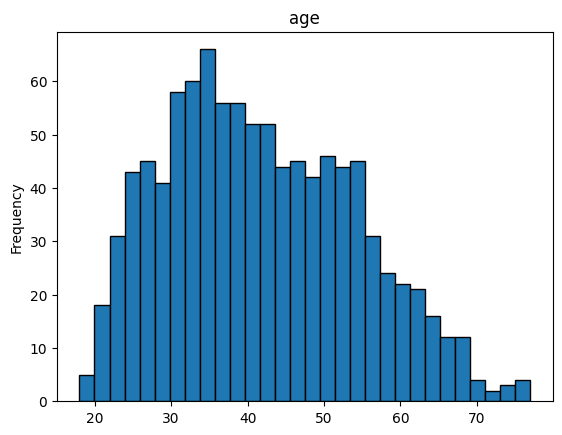

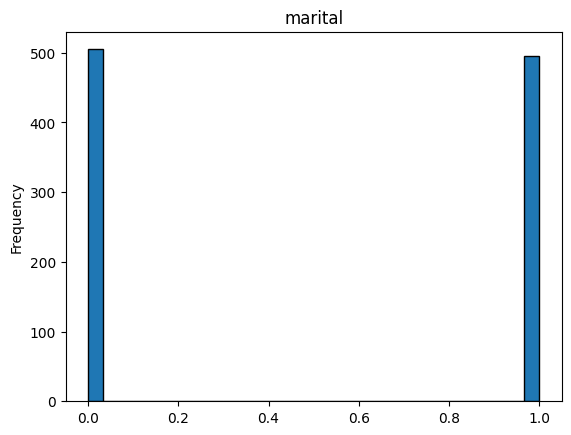

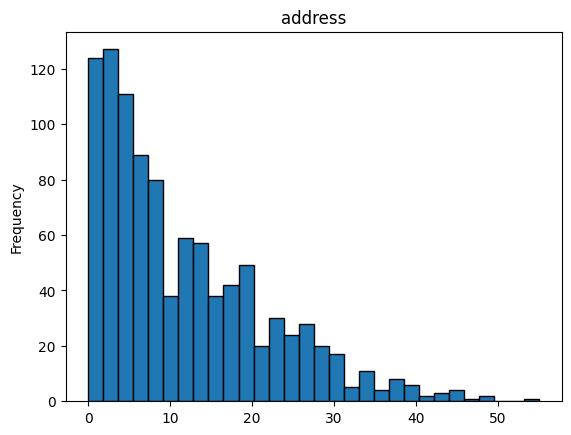

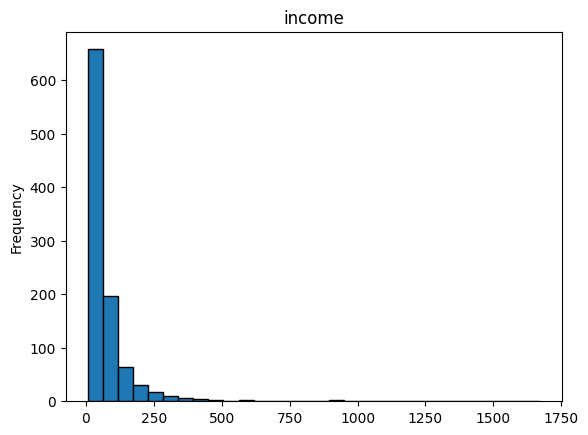

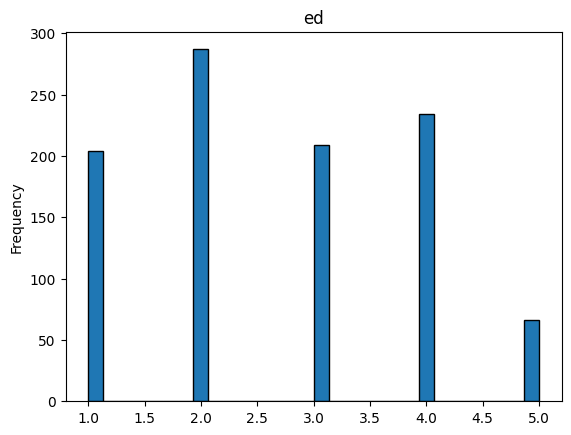

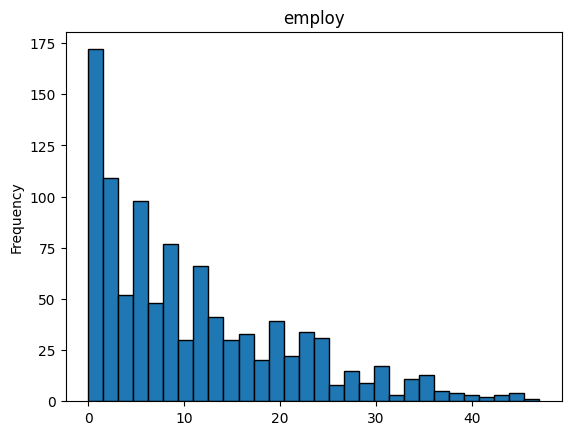

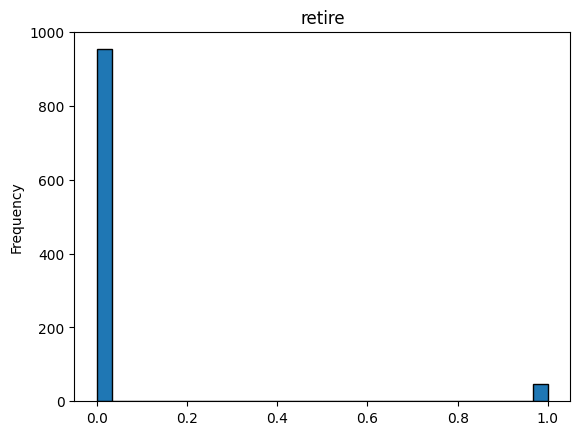

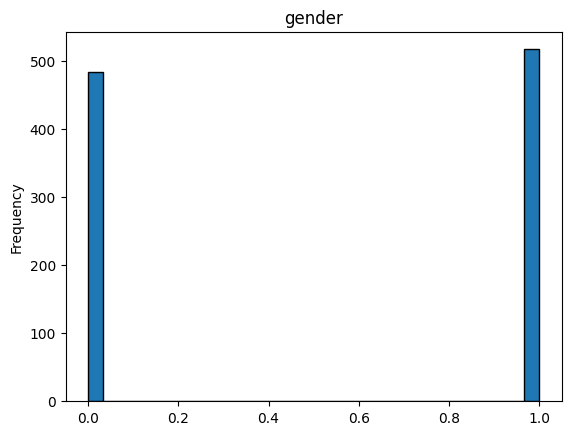

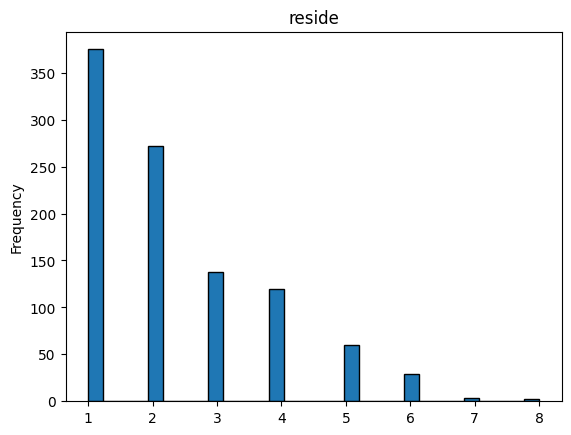

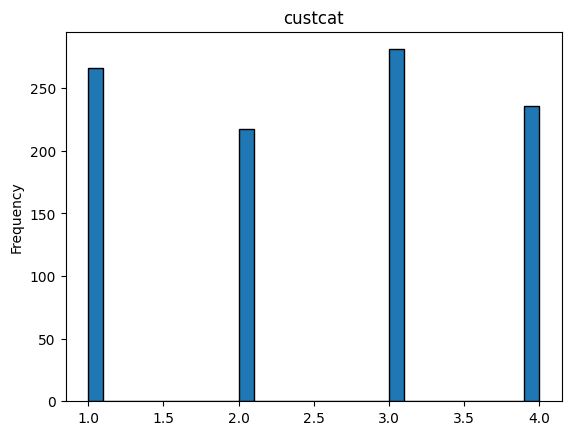

In [9]:

telefonkunden.hist(figsize=(10, 6), bins=30, color='skyblue', edgecolor='black', layout=(3, 4))
numeric_cols = telefonkunden.select_dtypes(include=['number']).columns
for col in numeric_cols:
    telefonkunden[col].plot(kind='hist', bins=30, edgecolor='black')
    plt.title(col)
    plt.show()

In [ ]:
###### K-Nearest Neighbors (KNN) ######

In [8]:
# - 2. den Datensatz in Trainings- und Lerndatensatz aufteilen

# Dafür erstellen wir zunächst (wie auch bei den Weinen) zwei separate Datensätze mit den Input- (X) und der Outputvariablen (Y).
X = telefonkunden.drop(columns=['custcat'])
Y = telefonkunden.custcat
X.head()
Y.head()

# Jetzt können wir wieder mit train_test_split aus scikit-learn den Datensatz in Trainings- und Testdaten aufteilen

X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1, stratify = Y)
# Wie vorher: Wir teilen in 20% Lern- und 80% Testdaten auf (test_size), lassen die Aufteilung zur Reproduzierbarkeit der Ergebnisse immer gleich aufteilen (random_state) und sorgen dafür, dass die Klassen gleichmäßig aufgeteilt sind (stratify).

# Nun wird das Modelll trainiert. Wir verwenden zunächst k=5 Nachbarn.
knn = KNeighborsClassifier(n_neighbors = 5)
vorhersage_scikit = knn.fit(X_training, Y_training)

In [9]:
# - 3. eine Vorhersage mit dem kNN-Algorithmus treffen
vorhersage_scikit=knn.predict(X_test)

In [11]:
#Ergebnis 
knn.score(X_test, Y_test)

0.335

In [35]:
# Die bisherige Vorgehensweise hieß Holdout-Methode: Man reserviert eine Menge als Testdaten, den Rest als Trainingsdaten. Allerdings kann dies zu Probleme führen: 
# Vielleicht wurden die Daten unglücklich aufgeteilt?Zur Lösung bedient man sich der sog. k-fache Kreuzvalidierung, wie auch in der Vorlesung besprochen: 
# Bei der Kreuzvalidierung wird der Datensatz zufällig in Gruppen aufgeteilt. Eine der Gruppen wird als Testsatz und der Rest als Trainingssatz verwendet. 
# Das Modell wird mit dem Trainingssatz trainiert und mit dem Testsatz bewertet. Dann wird der Prozess wiederholt, bis jede einzelne Gruppe als Testsatz verwendet wurde. 
# Bei der 5-fachen Kreuzvalidierung werden also die Daten in 5 Gruppen aufgeteilt und 5-mal angepasst und bewertet, wobei jedes Mal der Genauigkeitswert in einem Array abgespeichert wird. So hat jede der 5 Gruppen eine Chance, als Testdatensatz zu dienen.
# Neuen Klassifikator verwenden, mit unserem idealen k=5
klassifikator_kreuzvalidierung = KNeighborsClassifier(n_neighbors=13)

# Genauigkeiten mit einem trainierten Modell mit 5 Gruppen
kreuzvalidierung_genauigkeiten = cross_val_score(klassifikator_kreuzvalidierung, X, Y, cv = 5)

# Genauigkeiten ausgeben
print(kreuzvalidierung_genauigkeiten)
# Nehmen wir einfach mal den Mittelwert dieser Genauigkeiten, und sehen, dass wir die Genauigkeit nochmals erhöhen konnten von ca. 66% auf ca. 71%!
print(np.mean(kreuzvalidierung_genauigkeiten))
# Wir konnten also eine Erhöhung der Genauigkeit erreichen!

[0.395 0.32  0.285 0.35  0.405]
0.35100000000000003


In [13]:
# Definieren wir zunächst einen neuen Klassifikator:
knn2 = KNeighborsClassifier()

# Nun erstellen wir das Dictionary mit den k-Werten für die Hyperparameter-Optimimerung, die uns interessieren:
k_grid = {'n_neighbors': np.arange(1, 50)}

# Nun lassen wir die Grid-Suche für jedes k durchlaufen, jeweils mit einer 5-fachen Kreuzvalidierung:
knn_grid = GridSearchCV(knn2, k_grid, cv = 5)

# Nun trainieren wir das Modell mit den Daten und den darüber definierten Parametern:
knn_grid.fit(X, Y)

# Was ist nun die beste Anzahl an Nachbarn?
print(knn_grid.best_params_)

# Der Genauigkeits-Score bei dieser Anzahl an Nachbarn ist nochmal höher
knn_grid.best_score_

{'n_neighbors': np.int64(42)}


np.float64(0.365)

In [14]:
# Man kann die Funktion auch alle Genauigkeits-Scores ausgeben lassen. Dies sind also für jedes k die durchschnittlichen Werte der Genauigkeits-Scores aus je allen 5 Durchläufen der Kreuzvalidierung!
scores=knn_grid.cv_results_['mean_test_score']
print(scores)

[0.291 0.301 0.307 0.312 0.31  0.316 0.312 0.323 0.326 0.329 0.327 0.33
 0.351 0.331 0.344 0.338 0.324 0.335 0.339 0.33  0.336 0.341 0.339 0.35
 0.35  0.35  0.348 0.358 0.353 0.351 0.35  0.342 0.354 0.353 0.343 0.35
 0.348 0.352 0.348 0.358 0.358 0.365 0.36  0.351 0.354 0.354 0.355 0.361
 0.361]


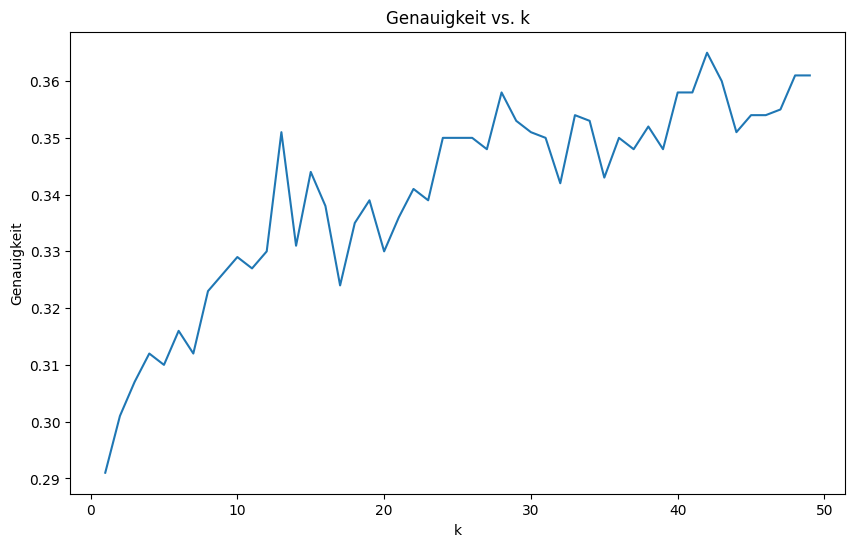

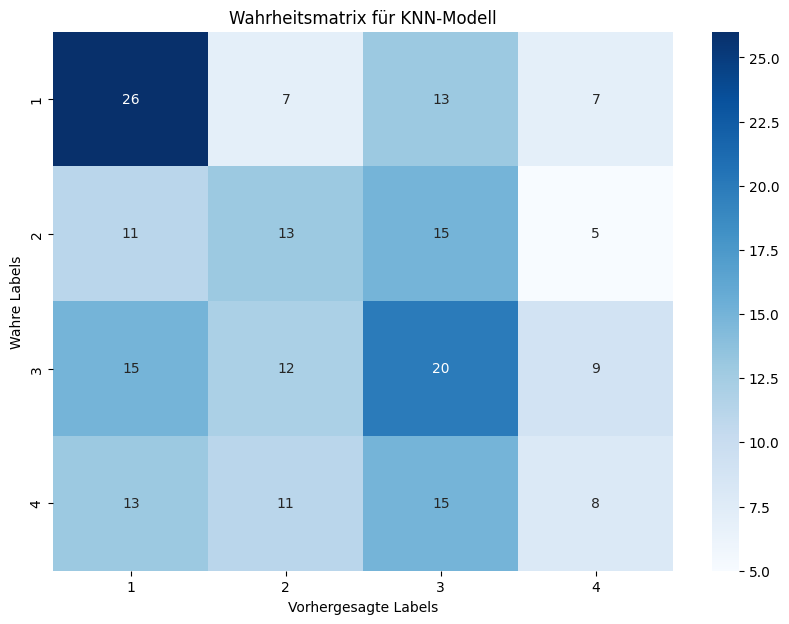

In [36]:
# Wir definieren eine Bildgröße
plt.figure(figsize=(10,6))
# Wir plotten auf der x-Achse von 1 bis 49 (also die k's die wir oben in der for-Schleife durchprobiert haben)
plt.plot(range(1, len(scores) + 1), scores)
# Wir beschriften noch die Achsen
plt.title('Genauigkeit vs. k')
plt.xlabel('k')
plt.ylabel('Genauigkeit')

# Wahrheitsmatrix für das KNN-Modell
conf_matrix = confusion_matrix(Y_test, vorhersage_scikit)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.title('Wahrheitsmatrix für KNN-Modell')
plt.show()

In [ ]:
###################### KNN Adriano #################################

0.395
[0.345, 0.325, 0.38, 0.355, 0.335, 0.33, 0.355, 0.335, 0.35, 0.31, 0.345, 0.34, 0.38, 0.355, 0.36, 0.36, 0.38, 0.39, 0.395, 0.375, 0.37, 0.39, 0.37, 0.38, 0.385, 0.385, 0.36, 0.35, 0.335, 0.35, 0.345, 0.345, 0.335, 0.35, 0.36, 0.35, 0.365, 0.38, 0.395, 0.38, 0.385, 0.375, 0.355, 0.35, 0.35, 0.35, 0.36, 0.365, 0.355, 0.36, 0.355, 0.36, 0.365, 0.365, 0.375, 0.37, 0.375, 0.38, 0.38, 0.37, 0.365, 0.37, 0.385, 0.39, 0.37, 0.385, 0.4, 0.39, 0.38, 0.39, 0.385, 0.385, 0.38, 0.385, 0.385, 0.395, 0.39, 0.385, 0.39, 0.385, 0.38, 0.39, 0.37, 0.39, 0.405, 0.38, 0.385, 0.37, 0.36, 0.36, 0.36, 0.355, 0.35, 0.35, 0.36, 0.36, 0.365, 0.375, 0.385]


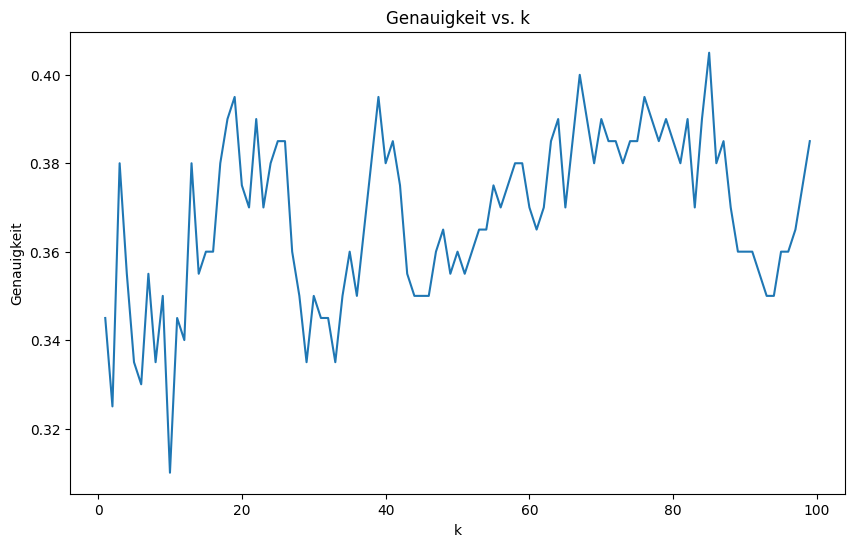

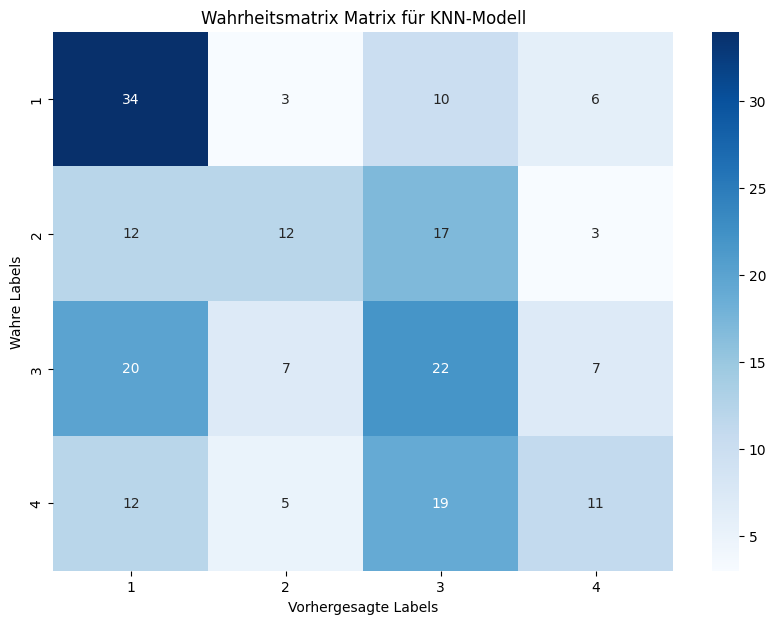

In [24]:
# Merkmale und Zielvariable definieren
X = telefonkunden[['tenure','age','income','address','employ','ed']] # Merkmale, die für die Vorhersage von 'custcat' relevant sind
Y = telefonkunden['custcat']

# Daten in Trainings- und Testset aufteilen 80/20 Split|Stratified --> gleiche Verteilung der Zielvariable
X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

# KNN-Modell erstellen und trainieren
knn = KNeighborsClassifier(n_neighbors=19)  # Anzahl der Nachbarn 
vorhersage_scikit = knn.fit(X_training, Y_training)

vorhersage_scikit = knn.predict(X_test)

# Genauigkeit der Vorhersage
print(accuracy_score(Y_test, vorhersage_scikit))

# Berechnung der Genauigkeit für verschiedene Werte von n_neighbors
scores = []
for k in range(1, 100):
	knn = KNeighborsClassifier(n_neighbors=k)
	knn.fit(X_training, Y_training)
	y_pred = knn.predict(X_test)
	scores.append(accuracy_score(Y_test, y_pred))

# Berechnung der Genauigkeit für verschiedene Werte von n_neighbors
scores = []
for k in range(1, 100):
	knn = KNeighborsClassifier(n_neighbors=k)
	knn.fit(X_training, Y_training)
	y_pred = knn.predict(X_test)
	scores.append(accuracy_score(Y_test, y_pred))

# Ausgabe der Genauigkeits-Scores
print(scores)

# Dies kann man auch noch grafisch darstellen. Dafür brauchen wir die matplotlib als gute Bibliothek für Datenvisualisierung:
import matplotlib.pyplot as plt

# Wir definieren eine Bildgröße
plt.figure(figsize=(10, 6))
# Wir plotten auf der x-Achse von 1 bis 100 (also die k's die wir oben in der for-Schleife durchprobiert haben)
plt.plot(range(1, 100), scores)
# Wir beschriften noch die Achsen
plt.title('Genauigkeit vs. k')
plt.xlabel('k')
plt.ylabel('Genauigkeit')
plt.show()

# Wahrheits Matrix
conf_matrix = confusion_matrix(Y_test, vorhersage_scikit)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.title('Wahrheitsmatrix Matrix für KNN-Modell')
plt.show()

In [3]:
#### Hyperparameter-Tuning mit GridSearchCV für KNN ####

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[['tenure', 'age', 'income', 'ed', 'gender', 'address']]  # Auswahl der relevanten Merkmale
y = telefonkunden['custcat']  # Zielvariable

# Datenaufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # Aufteilung der Daten in Trainings- und Testset

# Feature-Skalierung
scaler = StandardScaler()  # Initialisierung des StandardScalers
X_train = scaler.fit_transform(X_train)  # Anpassung und Transformation der Trainingsdaten
X_test = scaler.transform(X_test)  # Transformation der Testdaten

# Hyperparameter-Raster für KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],  # Anzahl der Nachbarn
    'weights': ['uniform', 'distance'],  # Gewichtung der Nachbarn
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distanzmetriken
}

# GridSearchCV-Objekt für KNN erstellen
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')  # Initialisierung von GridSearchCV mit KNN und Hyperparameter-Raster

# GridSearchCV auf Trainingsdaten anwenden
grid_search_knn.fit(X_train, y_train)  # Training des Modells mit GridSearchCV

# Beste Hyperparameter anzeigen
print("Beste Hyperparameter für KNN:", grid_search_knn.best_params_)  # Ausgabe der besten Hyperparameter

# Bestes Modell aus GridSearchCV extrahieren
best_knn = grid_search_knn.best_estimator_  # Extraktion des besten Modells

# Vorhersagen mit dem besten Modell machen
y_pred_best_knn = best_knn.predict(X_test)  # Vorhersagen für die Testdaten

# Klassifikationsbericht für das beste Modell anzeigen
print("Beste KNN Klassifikationsbericht:")  # Ausgabe des Klassifikationsberichts
print(classification_report(y_test, y_pred_best_knn))  # Klassifikationsbericht anzeigen

# Genauigkeit des besten Modells anzeigen
print("Beste KNN Genauigkeit:", accuracy_score(y_test, y_pred_best_knn))  # Ausgabe der Genauigkeit des Modells

Beste Hyperparameter für KNN: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'distance'}
Beste KNN Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.38      0.38      0.38        53
           2       0.45      0.39      0.41        44
           3       0.43      0.50      0.46        56
           4       0.39      0.36      0.37        47

    accuracy                           0.41       200
   macro avg       0.41      0.41      0.41       200
weighted avg       0.41      0.41      0.41       200

Beste KNN Genauigkeit: 0.41


In [37]:
### Normalisierung der Daten ###

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[['tenure','age','income','ed', 'gender', 'address']]
y = telefonkunden['custcat']

# Datenaufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature-Skalierung
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# k-NN Modell erstellen und trainieren
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Vorhersagen machen
y_pred = knn.predict(X_test)

# Modellbewertung
print("k-NN Klassifikationsbericht:")
print(classification_report(y_test, y_pred))
print("k-NN Genauigkeit:", accuracy_score(y_test, y_pred))

k-NN Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.38      0.53      0.44        53
           2       0.37      0.41      0.39        44
           3       0.49      0.46      0.48        56
           4       0.42      0.21      0.28        47

    accuracy                           0.41       200
   macro avg       0.41      0.40      0.40       200
weighted avg       0.42      0.41      0.40       200

k-NN Genauigkeit: 0.41


c:\Users\adria\anaconda3\envs\myenv\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


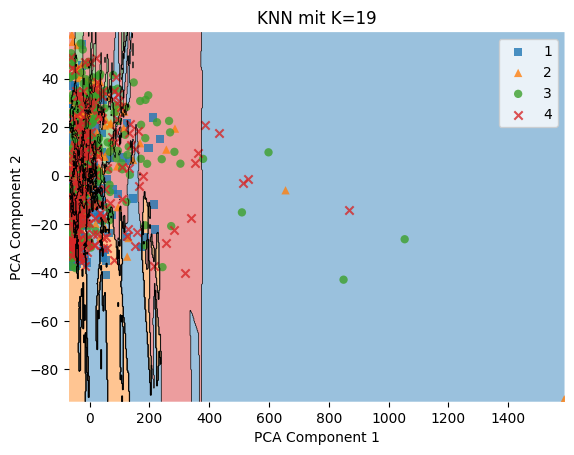

In [43]:
##################### KNN Visualisierung ################
from sklearn import neighbors
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Convert DataFrame to NumPy array
X_np = X.values

# Reduce the dimensionality of the dataset to 2 features using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_np)

# Trainiere und visualisiere KNN mit verschiedenen k-Werten
for k in [19]:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_pca, Y.values)

    plot_decision_regions(X_pca, Y.values, clf=knn, legend=2, scatter_kwargs={"edgecolor": "none"})
    
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"KNN mit K={k}")
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
##################### Random Forest #####################
# Random Forest ist ein Ensemble (mehrere "Lernende" werden auf das selbe Ziel trainier)-Lernalgorithmus, der aus mehreren Entscheidungsbäumen besteht.
# Jeder Baum im Wald wird auf einem zufälligen Unterdatensatz des Datensatzes trainiert.

Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.47      0.57      0.51        53
           2       0.40      0.27      0.32        44
           3       0.39      0.45      0.42        56
           4       0.36      0.32      0.34        47

    accuracy                           0.41       200
   macro avg       0.40      0.40      0.40       200
weighted avg       0.41      0.41      0.40       200

Genauigkeit: 0.41


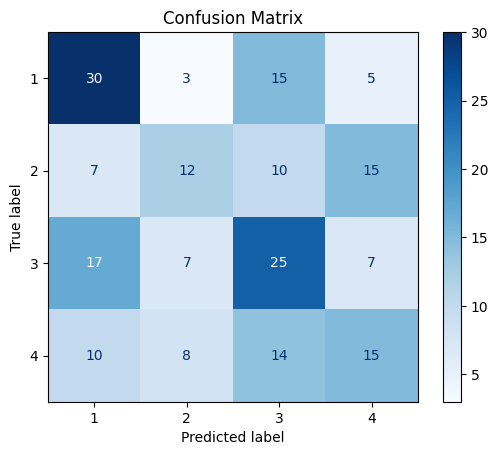

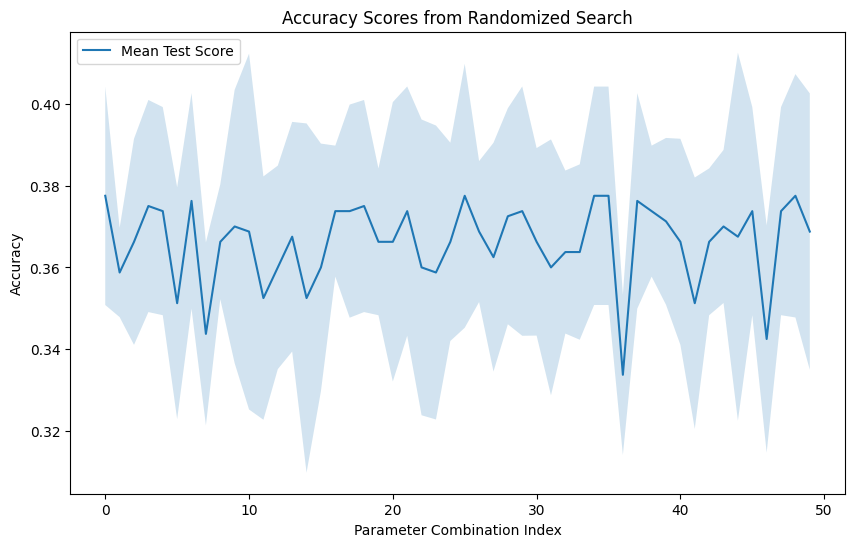

In [ ]:
#Random Forest Test - 41% Genauigkeit
telefonkunden = pd.read_csv('telefonkunden.csv')


selected_features = ['region', 'tenure', 'age', 'income', 'ed', 'employ', 'reside']

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[selected_features]
Y = telefonkunden['custcat']

# Datenaufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

# Hyperparameter-Tuning für den Random Forest
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(RandomForestClassifier(random_state=1), param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', random_state=1, n_jobs=-1)
random_search.fit(X_train, y_train)

# Bestes Modell auswählen
best_rf = random_search.best_estimator_

# Vorhersagen machen
y_pred = best_rf.predict(X_test)

# Modellbewertung
print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred))
print("Genauigkeit:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plot Accuracy
results = random_search.cv_results_
plt.figure(figsize=(10, 6))
plt.plot(results['mean_test_score'], label='Mean Test Score')
plt.fill_between(range(len(results['mean_test_score'])), 
                 results['mean_test_score'] - results['std_test_score'], 
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2)
plt.title('Accuracy Scores from Randomized Search')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
# Hyperparameter-Raster für Random Forest
# Ziel: Das optimale Set an Parametern für das Modell finden.
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Anzahl der Bäume im Wald
    'max_depth': [None, 10, 20, 30],  # Maximale Tiefe der Bäume
    'min_samples_split': [2, 5, 10],  # Minimale Anzahl von Proben, die erforderlich sind, um einen Knoten zu teilen
    'min_samples_leaf': [1, 2, 4]     # Minimale Anzahl von Proben, die in einem Blattknoten erforderlich sind
}

# GridSearchCV-Objekt für Random Forest erstellen
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=1), param_grid_rf, cv=5, scoring='accuracy')
# GridSearchCV: Automatisiert die Suche nach den besten Hyperparametern.
# param_grid_rf: Hyperparameter-Raster, über das iteriert wird.
# cv =5: Fünf-Fold-Cross-Validation zur Bewertung jedes Parameter-Sets.
# scoring='accuracy': Die Genauigkeit wird als Metrik verwendet, um die Leistung zu bewerten.

# GridSearchCV auf Trainingsdaten anwenden
grid_search_rf.fit(X_training, Y_training)

# Beste Hyperparameter anzeigen
print("Beste Hyperparameter für Random Forest:", grid_search_rf.best_params_)

# Bestes Modell aus GridSearchCV extrahieren
best_rf = grid_search_rf.best_estimator_

# Vorhersagen mit dem besten Modell machen
y_pred_best_rf = best_rf.predict(X_test)

# Klassifikationsbericht für das beste Modell anzeigen
print("Beste Random Forest Klassifikationsbericht:")
print(classification_report(Y_test, y_pred_best_rf))

# Genauigkeit des besten Modells anzeigen
print("Beste Random Forest Genauigkeit:", accuracy_score(Y_test, y_pred_best_rf))

Beste Hyperparameter für Random Forest: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Beste Random Forest Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.47      0.57      0.51        53
           2       0.40      0.27      0.32        44
           3       0.39      0.45      0.42        56
           4       0.36      0.32      0.34        47

    accuracy                           0.41       200
   macro avg       0.40      0.40      0.40       200
weighted avg       0.41      0.41      0.40       200

Beste Random Forest Genauigkeit: 0.41


In [ ]:
##################### Neuronales Netz #####################
# Ein neuronales Netz ist ein Modell, das aus einer Reihe von miteinander verbundenen Neuronen besteht, die in Schichten organisiert sind.
# Jedes Neuron nimmt Eingaben, führt eine Berechnung durch und gibt eine Ausgabe weiter. Die Ausgaben der Neuronen in einer Schicht werden an die nächste Schicht weitergegeben.
# Neuronale Netze können verwendet werden, um komplexe nichtlineare Beziehungen in den Daten zu modellieren und Vorhersagen zu treffen.

In [31]:
# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[['tenure','age','income','ed', 'gender', 'region']]  # Auswahl der relevanten Features
y = telefonkunden['custcat']  # Zielvariable

# Zielvariable in kategorische Form umwandeln
y = to_categorical(y)  # One-Hot-Encoding der Zielvariable

# Datenaufteilung in Trainings- und Testdaten
X_training, X_test, Y_training, Y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # Aufteilung der Daten in Trainings- und Testset

# Feature-Skalierung
scaler = StandardScaler()  # Initialisierung des StandardScalers
X_train = scaler.fit_transform(X_training)  # Anpassung und Transformation der Trainingsdaten
X_test = scaler.transform(X_test)  # Transformation der Testdaten

# Neuronales Netz erstellen
model = Sequential()  # Initialisierung des Modells
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Hinzufügen der ersten Schicht mit 64 Neuronen und ReLU-Aktivierung (Aktivierungsfunktion)
model.add(Dense(32, activation='relu'))  # Hinzufügen der zweiten Schicht mit 32 Neuronen und ReLU-Aktivierung
model.add(Dense(Y_training.shape[1], activation='softmax'))  # Hinzufügen der Ausgabeschicht mit Softmax-Aktivierung

# Modell kompilieren
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Kompilierung des Modells mit Verlustfunktion, Optimierer und Metrik

# Modell trainieren
model.fit(X_train, Y_training, epochs=50, validation_data=(X_test, Y_test), verbose=0)  # Training des Modells mit 50 Epochen und Validierungsdaten

# Vorhersagen machen
y_pred = model.predict(X_test)  # Vorhersagen für die Testdaten
y_pred_classes = y_pred.argmax(axis=1)  # Umwandlung der Vorhersagen in Klassen
y_test_classes = Y_test.argmax(axis=1)  # Umwandlung der Testdaten in Klassen

# Modellbewertung
print("Neuronales Netz Klassifikationsbericht:")  # Ausgabe des Klassifikationsberichts
print(classification_report(y_test_classes, y_pred_classes))  # Klassifikationsbericht anzeigen
print("Neuronales Netz Genauigkeit:", accuracy_score(y_test_classes, y_pred_classes))  # Genauigkeit des Modells anzeigen

c:\Users\adria\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Neuronales Netz Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.44      0.58      0.50        53
           2       0.37      0.25      0.30        44
           3       0.44      0.57      0.50        56
           4       0.37      0.21      0.27        47

    accuracy                           0.42       200
   macro avg       0.40      0.40      0.39       200
weighted avg       0.41      0.42      0.40       200

Neuronales Netz Genauigkeit: 0.42


In [ ]:
##################### NN Optimierungen #####################

# Batch Normalization: Die Batch-Normalisierungsschichten (BatchNormalization()) helfen, die Trainingsstabilität zu verbessern und die Konvergenz zu beschleunigen.
# Dropout: Die Dropout-Schichten (Dropout(0.5)) helfen, Überanpassung zu vermeiden, indem sie zufällig Neuronen während des Trainings deaktivieren.
# Early Stopping: Der Early Stopping Callback (EarlyStopping) beendet das Training, wenn sich die Validierungsleistung nicht mehr verbessert, um Überanpassung zu vermeiden.
# Erweiterte Optimierer: Der Adam-Optimierer (optimizer='adam') wird verwendet, um die Lernrate adaptiv anzupassen.

In [32]:
# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[['tenure','age','income','ed', 'gender', 'region']] # wenn alle Feautures verwendet werden ist die Genauigkeit identisch
y = telefonkunden['custcat']

# Zielvariable in kategorische Form umwandeln
y = to_categorical(y)

# Datenaufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature-Skalierung
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Neuronales Netz erstellen
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())  # Batch-Normalisierung hinzufügen
model.add(Dropout(0.5))  # Dropout-Schicht hinzufügen
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())  # Batch-Normalisierung hinzufügen
model.add(Dropout(0.5))  # Dropout-Schicht hinzufügen
model.add(Dense(y_train.shape[1], activation='softmax'))

# Modell kompilieren
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modell trainieren
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

# Vorhersagen machen
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)

# Modellbewertung
print("Optimiertes Neuronales Netz Klassifikationsbericht:")
print(classification_report(y_test_classes, y_pred_classes))
print("Optimiertes Neuronales Netz Genauigkeit:", accuracy_score(y_test_classes, y_pred_classes))

c:\Users\adria\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Optimiertes Neuronales Netz Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.43      0.51      0.47        53
           2       0.50      0.25      0.33        44
           3       0.42      0.50      0.46        56
           4       0.44      0.45      0.44        47

    accuracy                           0.43       200
   macro avg       0.45      0.43      0.42       200
weighted avg       0.44      0.43      0.43       200

Optimiertes Neuronales Netz Genauigkeit: 0.435


In [ ]:
############# Supported Vector Machine ################
# Ist ein überwachtes maschinelles Lernverfahren, das sowohl für Klassifikationsprobleme als auch für Regressionsaufgaben eingesetzt werden kann. 
# Besonders effektiv bei der Trennung von Daten in hochdimensionalen Räumen. 

In [ ]:
# SVM Niklas 45,5% Genauigkeit

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, label_binarize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Datensatz laden
telefonkunden = pd.read_csv('telefonkunden.csv')

# Ausgewählte Features mit tatsächlichen Spaltennamen definieren
selected_features = ['region', 'tenure', 'age', 'income', 'ed', 'employ', 'reside']

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[selected_features]
Y = telefonkunden['custcat']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Datenaufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=1, stratify=Y)

# Hyperparameter-Tuning für den SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(SVC(random_state=1, probability=True), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Bestes Modell auswählen
best_svm = grid_search.best_estimator_

# Vorhersagen machen
y_pred = best_svm.predict(X_test)

# Modellbewertung
print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred))
print("Genauigkeit:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# ROC Curve und Precision-Recall Curve für jede Klasse berechnen
y_test_binarized = label_binarize(y_test, classes=np.unique(Y))
y_prob = best_svm.predict_proba(X_test)

# ROC Curve
plt.figure(figsize=(10, 6))
for i in range(y_test_binarized.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc = roc_auc_score(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label='Klasse %d (AUC = %0.2f)' % (i, roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(10, 6))
for i in range(y_test_binarized.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(recall, precision, lw=2, label='Klasse %d' % i)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Entscheidungsgrenze visualisieren (funktioniert nur, wenn wir auf 2 Features reduzieren)
def plot_decision_boundary(X, y, model):
    h = .02  # Schrittweite im Mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('SVM Entscheidungsgrenze')
    plt.show()

# Reduzieren auf 2 Features zur Visualisierung
X_reduced = X_scaled[:, :2]
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, Y, test_size=0.2, random_state=1, stratify=Y)

# Trainiere den SVM auf reduzierten Features
grid_search_reduced = GridSearchCV(SVC(random_state=1), param_grid, cv=5, scoring='accuracy')
grid_search_reduced.fit(X_train_reduced, y_train_reduced)
best_svm_reduced = grid_search_reduced.best_estimator_

# Plot der Entscheidungsgrenze
plot_decision_boundary(X_test_reduced, y_test_reduced, best_svm_reduced)